In [1]:
import sys

import torch

sys.path.append(".")
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from ddm_utils import (
    encode_zero_choice_as_negative_rts,
    parallel_simulator,
    simulate_ddm_collapsing,
)
from sbi.analysis import pairplot
from sbi.inference import MNLE
from scipy.stats import binom

# Colorblind color palette
# colors = [
#     "#377eb8",
#     "#ff7f00",
#     "#4daf4a",
#     "#f781bf",
#     "#a65628",
#     "#984ea3",
#     "#999999",
#     "#e41a1c",
#     "#dede00",
# ]
from paper.colors import colors
colors_red = mpl.cm.Reds(np.linspace(0.3, 1, 5))
tue = (165 / 255, 30 / 255, 55 / 255)
gold = (180 / 255, 160 / 255, 105 / 255)
dark = (50 / 255, 65 / 255, 75 / 255)

/Users/michaeldeistler/anaconda3/envs/sbitutorial/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading results
with open("data/sbi_ddm_collapsing_prior_theta_x.pkl", "rb") as f:
    prior, theta, x = pickle.load(f)

density_estimator = torch.load("data/ddm_collapsing_estimator.pt")
# build posterior with pre-trained density estimator
inferer = MNLE()

mcmc_parameters = {
    "num_chains": 100,
    "thin": 2,
    "warmup_steps": 500,
    "init_strategy": "sir",
}
posterior = inferer.build_posterior(
    prior=prior, density_estimator=density_estimator, mcmc_parameters=mcmc_parameters
)

with open("data/ddm_collapsing_diagnostics.pt", "rb") as f:
    ranks, daps = pickle.load(f).values()
    num_sbc_samples = len(ranks)

/var/folders/kv/39t9blx569l5_sxxzx89vb3c0000gn/T/ipykernel_72197/1020017217.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  density_estimator = torch.load("data/ddm_coll

In [3]:
# Generating observed data
seed = 42
simulator = parallel_simulator(num_workers=10, show_progress=True, seed=seed)(
    simulate_ddm_collapsing
)

num_trials = 100
theta_o1 = torch.tensor([[-0.125, 0.35, -0.2, 0.5, -0.7]])
theta_o2 = torch.tensor([[0.125, 0.55, 0.2, 0.3, -0.5]])
x_o1 = simulator(theta_o1.repeat(num_trials, 1))
x_o2 = simulator(theta_o2.repeat(2 * num_trials, 1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 899.81it/s]


In [4]:
# (re-)Run inference
rerun = False
num_posterior_samples = 1000

if rerun:
    posterior_samples1 = posterior.sample((num_posterior_samples,), x=x_o1)
    posterior_samples2 = posterior.sample((num_posterior_samples,), x=x_o2)

    with open("data/ddm_collapsing_posterior_samples.pkl", "wb") as f:
        torch.save(
            {
                "posterior_samples1": posterior_samples1,
                "posterior_samples2": posterior_samples2,
            },
            f,
        )
else:
    with open("data/ddm_collapsing_posterior_samples.pkl", "rb") as f:
        posterior_samples = torch.load(f)
        posterior_samples1 = posterior_samples["posterior_samples1"]
        posterior_samples2 = posterior_samples["posterior_samples2"]

/var/folders/kv/39t9blx569l5_sxxzx89vb3c0000gn/T/ipykernel_72197/1960622729.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  posterior_samples = torch.load(f)


In [5]:
# Generate predictive samples
num_predictive_samples = 1000
x_o_dist1 = simulator(theta_o1.repeat(num_predictive_samples, 1))
x_o_dist1 = encode_zero_choice_as_negative_rts(x_o_dist1)
x_o_dist2 = simulator(theta_o2.repeat(num_predictive_samples, 1))
x_o_dist2 = encode_zero_choice_as_negative_rts(x_o_dist2)

posterior_pred1 = encode_zero_choice_as_negative_rts(simulator(posterior_samples1))
posterior_pred2 = encode_zero_choice_as_negative_rts(simulator(posterior_samples2))

prior_pred = encode_zero_choice_as_negative_rts(x[:num_predictive_samples])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1171.64it/s]


In [6]:
with open("data/ddm_collapsing_calibration_samples.pt", "rb") as fh:
    thetas, xs, sbc_posterior_samples = pickle.load(fh).values()

In [7]:
# TARP and SBC

from sbi.diagnostics.sbc import _run_sbc
from sbi.diagnostics.tarp import _run_tarp, get_tarp_references

_ = torch.manual_seed(0)
marginal_ranks = _run_sbc(
    thetas,
    xs,
    posterior=posterior,
    posterior_samples=sbc_posterior_samples,
    reduce_fns="marginals",
)
ep_ranks = _run_sbc(
    thetas,
    xs,
    posterior=posterior,
    posterior_samples=sbc_posterior_samples,
    reduce_fns=posterior.potential,
)

Calculating ranks for 200 sbc samples.: 100%|███████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 202.82it/s]


In [8]:
tarp_references = get_tarp_references(thetas)
ecp, alpa = _run_tarp(
    posterior_samples=sbc_posterior_samples,
    thetas=thetas,
    references=tarp_references,
    num_bins=100,
)

/var/folders/kv/39t9blx569l5_sxxzx89vb3c0000gn/T/ipykernel_72197/1919699960.py:17: DeprecationWarning: you passed deprecated arguments **kwargs: ['samples_colors', 'kde_offdiag', 'contour_offdiag', 'scatter_offdiag', 'hist_diag', 'points_offdiag', 'points_diag', 'points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, ax = pairplot(


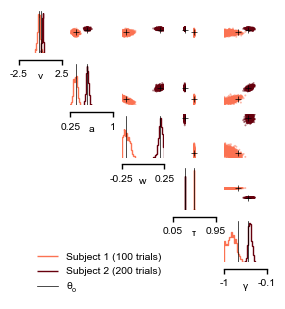

In [9]:
nbins = 100
histtype = "step"
repeats = 50
# how to use latex typesetting
# mpl.rcParams["text.usetex"] = True
# mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
labels = [r"$v$", r"$a$", r"$w$", r"$\tau$", r"$\gamma$"]
num_params = len(labels)
limits = [
    [prior.base_dist.low[i].item(), prior.base_dist.high[i].item()]
    for i in range(prior.base_dist.low.shape[0])
]

# panel c
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(num_params, num_params, figsize=(3.2, 3.2))
    fig, ax = pairplot(
        [posterior_samples1, posterior_samples2],
        points=[theta_o1, theta_o2],
        limits=limits,
        ticks=limits,
        samples_colors=[colors["theta_shades"][1], colors["theta_shades"][4]],
        diag="hist",
        upper="scatter",
        kde_offdiag=dict(bw_method="scott", bins=50),
        contour_offdiag=dict(levels=[0.95], percentile=True),
        scatter_offdiag=dict(s=2),
        hist_diag=dict(bins=20, histtype=histtype),
        points_offdiag=dict(
            marker="+", markersize=4, mew=0.5
        ),
        points_diag=dict(linewidth=0.5),
        points_colors=["k", "k"],
        fig=fig,
        axes=ax,
        labels=labels,
    )
    for i in reversed(list(range(5))):
        ax[i, i].set_xlabel(labels[i], labelpad=-5)
        for label in ax[i, i].get_xticklabels():
            label.set_clip_on(False)
            label.set_zorder(10_000)
        ax[i, i].set_zorder(1000 - i)
    # mpl.rcParams["text.usetex"] = False
    plt.sca(ax[0, 0])
    legend = plt.legend(
        [
            "Subject 1 (100 trials)",
            "Subject 2 (200 trials)",
            r"$\theta_o$",
        ],
        bbox_to_anchor=(0.2, -4.35),
        # handlelength=0.6,
        loc=2,
    )
    for handle in legend.get_patches():
        handle.set_height(0.1)
        handle.set_y(handle.get_y() + 2.0)
    plt.savefig("svg/posterior_pairplot.svg")
    plt.show()

## Panel: Predictive checks

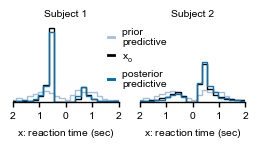

In [10]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 2, figsize=(3, 1.0), sharex=True, sharey=True)

    # plot for each subject
    plt.sca(ax[0])
    _, bins = np.histogram(prior_pred.numpy(), bins=50)
    for sample, color in zip(
        [prior_pred, x_o_dist1, posterior_pred1],
        [colors["x_shades"][0], colors["x_o"], colors["x"]],
    ):
        plt.hist(
            sample.numpy(),
            bins=bins,
            density=True,
            histtype=histtype,
            color=color,
            # linewidth=linewidth,
        )

    ax[0].spines["left"].set_visible(False)
    plt.yticks([])
    plt.xlabel("$x$: reaction time (sec)")
    ticks = np.array([-2, -1, 0, 1, 2])
    plt.xticks(ticks, abs(ticks))
    plt.xlim([ticks.min(), ticks.max()])

    # Arrows
#     plt.axvline(0, color="k")
    axis_setoff = -0.02

    plt.sca(ax[1])
    for sample, color in zip(
        [prior_pred, x_o_dist2, posterior_pred2],
        [colors["x_shades"][0], colors["x_o"], colors["x"]],
    ):
        plt.hist(
            sample.numpy(),
            bins=bins,
            density=True,
            histtype=histtype,
            color=color,
            # linewidth=linewidth,
        )

    ax[1].spines["left"].set_visible(False)
    plt.yticks([])
    plt.xlabel("$x$: reaction time (sec)")
    ticks = np.array([-2, -1, 0, 1, 2])
    plt.xticks(ticks, abs(ticks))
    plt.xlim([ticks.min(), ticks.max()])

    # Create handles for the legend
    prior_handle = plt.Line2D([0], [0], color=colors["x_shades"][0], lw=2)
    x_o_handle = plt.Line2D([0], [0], color=colors["x_o"], lw=2)
    post_handle1 = plt.Line2D([0], [0], color=colors["x"], lw=2)
    post_handle2 = plt.Line2D([0], [0], color=colors["x"], lw=2)

    # Group the two posterior handles
    post_handles = (post_handle1, post_handle2)

    # Create the legend with proper grouping
    handles = [prior_handle, x_o_handle, post_handles]
    labels = ["prior \npredictive", "$x_o$", "posterior \npredictive"]

    # Add legend with custom handler
    fig.legend(
        handles=handles,
        labels=labels,
        bbox_to_anchor=(0.67, 0.95),
        handlelength=0.6,
        frameon=False,
#         handler_map={tuple: plt.matplotlib.legend_handler.HandlerTuple(ndivide=None)},
    )
    ax[0].set_title("Subject 1")
    ax[1].set_title("Subject 2")

    # Arrows
#     plt.axvline(0, color="k")
    axis_setoff = -0.02

    plt.savefig("svg/posterior_predictives.svg")
    plt.show()

## Panel coverage checks combined

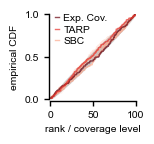

In [11]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.1, 1.1))

    # Plot for marginal ranks
    alphas = np.linspace(0.1, 0.7, num_params)
    lines = []
    for jj in range(num_params):
        hist, *_ = np.histogram(marginal_ranks[:, jj], bins=nbins, density=False)
        histcs = hist.cumsum()
        line = ax.plot(
            np.linspace(0, nbins, repeats * nbins),
            np.repeat(histcs / histcs.max(), repeats),
            label="SBC",
            color=colors["theta_shades"][0],
            alpha=alphas[jj],
        )
        lines.append(line[0])

    hb = binom(num_sbc_samples, p=1 / nbins).ppf(0.5) * np.ones(nbins)
    hbb = hb.cumsum() / hb.sum()
    hbb[-1] -= 1e-9
    lower = [binom(num_sbc_samples, p=p).ppf(0.005) for p in hbb]
    upper = [binom(num_sbc_samples, p=p).ppf(0.995) for p in hbb]

    ax.fill_between(
        x=np.linspace(0, nbins, repeats * nbins),
        y1=np.repeat(lower / np.max(lower), repeats),
        y2=np.repeat(upper / np.max(lower), repeats),
        color="grey",
        linewidth=0,
        alpha=0.2,
    )

    # Plot for EP and TARP
    hist, *_ = np.histogram(ep_ranks, bins=nbins, density=False)
    histcs = hist.cumsum()
    ep_line = ax.plot(
        np.linspace(0, nbins, repeats * nbins),
        np.repeat(histcs / histcs.max(), repeats),
        color=colors["theta_shades"][4],
        alpha=0.7,
        label="Exp. Cov.",
    )
    tarp_line = ax.plot(
        np.linspace(0, len(ecp), repeats * len(ecp)),
        np.repeat(ecp / ecp.max(), repeats),
        color=colors["theta_shades"][2],
        alpha=0.7,
        label="TARP",
    )

    hb = binom(num_sbc_samples, p=1 / nbins).ppf(0.5) * np.ones(nbins)
    hbb = hb.cumsum() / hb.sum()
    hbb[-1] -= 1e-9
    lower = [binom(num_sbc_samples, p=p).ppf(0.005) for p in hbb]
    upper = [binom(num_sbc_samples, p=p).ppf(0.995) for p in hbb]

    ax.fill_between(
        x=np.linspace(0, nbins, repeats * nbins),
        y1=np.repeat(lower / np.max(lower), repeats),
        y2=np.repeat(upper / np.max(lower), repeats),
        color="grey",
        linewidth=0.0,
        alpha=0.3,
    )

    # Set labels, ticks, and limits
    ax.set_yticks(np.linspace(0, 1, 3))
    ax.set_ylabel("empirical CDF")
    ax.set_ylim(0, 1)
    ax.set_xlim(0, nbins)
    ax.set_xticks(np.linspace(0, nbins, 3))
    ax.spines["left"].set_position(("axes", axis_setoff))
    ax.spines["bottom"].set_position(("axes", axis_setoff))
    ax.set_xlabel("rank / coverage level")

    legend2 = ax.legend(
        handles=[ep_line[0], tarp_line[0], lines[4]],
        loc="lower right",
        bbox_to_anchor=(0.78, 0.52),
        handlelength=0.4,
        handletextpad=0.4,
        labelspacing=0.2,
        # title="EP and TARP",
    )

    plt.savefig("svg/combined_coverage_checks.svg")
    plt.show()

In [12]:
import IPython.display as IPd
from svgutils.compose import SVG, Figure, Panel, Text


def svg(img):
    IPd.display(
        IPd.HTML(
            '<img src="{}" / >'.format(
                img,
            )
        )
    )


# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '10pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_normal = {'size': '7pt', 'font': 'Arial'}

dy = 154

f = Figure(
    "18.0cm",
    "7.3cm",
    
    Panel(
        SVG("svg/panel_a.svg").scale(1.0),
    ).move(0, 0),
    
    Panel(
        SVG("svg/posterior_pairplot.svg").scale(svg_scale),
        Text("c", -5, 0.0, **kwargs_text),
        Text("Posterior 1D and 2D marginals", 60, 0, **kwargs_text_normal),
    ).move(420, 12),
    
    Panel(
        SVG("svg/posterior_predictives.svg").scale(svg_scale),
        Text("d", -5, 0, **kwargs_text),
        Text("Posterior predictive checks", 50, 0, **kwargs_text_normal),
    ).move(5, dy),

    Panel(
        SVG("svg/combined_coverage_checks.svg").scale(svg_scale),
        Text("e", 5, 0, **kwargs_text),
        Text("Calibration diagnostics", 25, 0, **kwargs_text_normal),
    ).move(250, dy-2.5),
)

!mkdir -p fig
f.save("fig/fig7.svg")
svg("fig/fig7.svg")